In [2]:
import numpy as np
from scipy.stats import multinomial
import matplotlib.pyplot as plt

# Theta

The DB_V and DB_H events do not occur independently across the trials.

The 'DB_V', 'DB_H' and 'neither' events occur in the N samples as a multinomial distribution.

## As per paper

In [3]:
# plot the multinomial distribution

n = 40

theta = 0.25 * np.pi

p_dbh = 1 / 4 * (1 + np.cos(theta)) **2
p_dbv = 1 / 4 * (1 - np.cos(theta)) **2

p_neither = 1 - p_dbh - p_dbv

p = [p_dbh, p_dbv, p_neither]

multinom_db = multinomial(n, p)

multinom_db.pmf([40, 0, 0])

np.float64(3.1510503835036592e-06)

In [4]:
def get_multinom_difference_pmf(n, theta):
    z_range = np.arange(-n, n+1)
    pmf_z = np.zeros(2*n+1)

    p_dbh = 1 / 4 * (1 + np.cos(theta)) **2
    p_dbv = 1 / 4 * (1 - np.cos(theta)) **2
    p_neither = 1 - p_dbh - p_dbv

    p = [p_dbh, p_dbv, p_neither]

    multinom_db = multinomial(n, p)

    range_i = np.arange(0, n+1)

    # https://math.stackexchange.com/questions/562119/difference-of-two-binomial-random-variables
    for i,z in enumerate(z_range):
        pmf_z[i] = np.sum([multinom_db.pmf([z+i, i, n - z - 2*i]) for i in range_i])

    return z_range, pmf_z


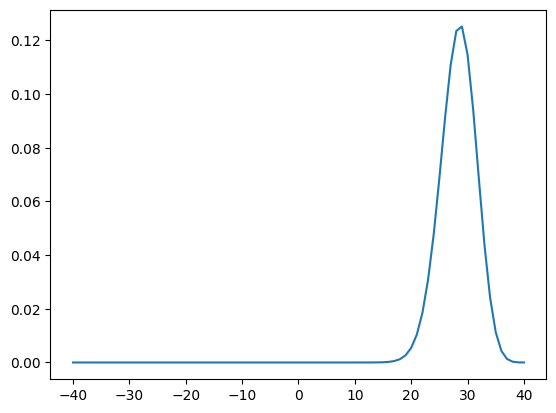

In [5]:
num_samples = 40
pmf_z = get_multinom_difference_pmf(num_samples, 0.25*np.pi)
plt.plot(pmf_z[0], pmf_z[1])
plt.show()

/Users/Joseph/Projects/EMQL/scratchpad/multi-parameter-estimation-interfering-photons/.venv/lib/python3.13/site-packages/scipy/stats/_multivariate.py:3320: RuntimeWarning: invalid value encountered in subtract
  return gammaln(n+1) + np.sum(xlogy(x, p) - gammaln(x+1), axis=-1)


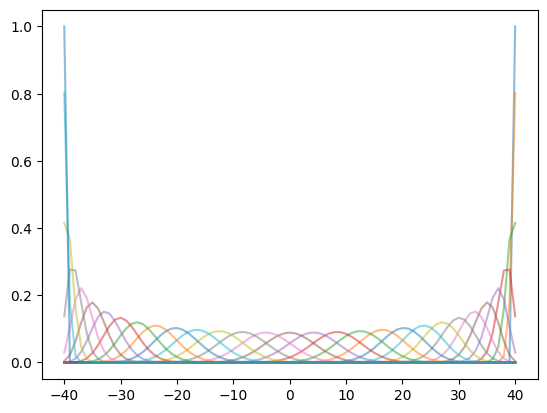

In [6]:
# show some of the pmfs for different thetas
theta_range = np.linspace(0, np.pi, 31)

# get the pmf for each theta
pmf_z = [get_multinom_difference_pmf(n, theta) for theta in theta_range]

# plot the pmfs
plt.figure()
for z_range, pmf in pmf_z:
    plt.plot(z_range, pmf, alpha=0.5)

plt.show()

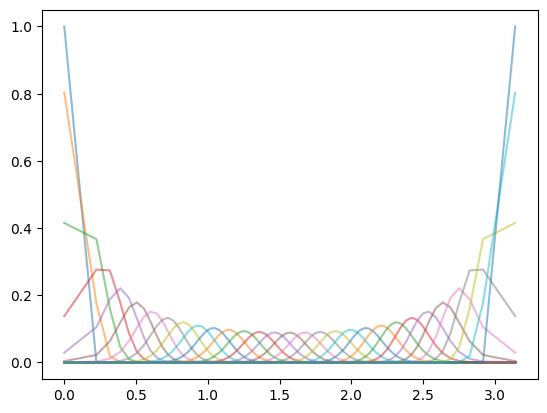

In [7]:
# show some of the pmfs for different thetas
theta_range = np.linspace(0, np.pi, 31)

# get the pmf for each theta
pmf_z = [get_multinom_difference_pmf(n, theta) for theta in theta_range]

# plot the pmfs
plt.figure()
for z_range, pmf in pmf_z:
    arccos_z = np.arccos(z_range/n)
    plt.plot(arccos_z, pmf, alpha=0.5)
    
plt.show()

In [8]:
def calculate_multinom_stats(theta_samples, n):
    theta_range = np.linspace(0, np.pi, theta_samples)
    pmf_z = [get_multinom_difference_pmf(n, theta) for theta in theta_range]

    z_range = np.arange(-n, n+1)
    arccos_z_range = np.arccos(z_range / n)
    variances = []
    means = []

    for _, pmf in pmf_z:
        mean = np.sum(arccos_z_range * pmf)
        var = np.sum((arccos_z_range) ** 2 * pmf) - mean ** 2

        means.append(mean)
        variances.append(var)

    return theta_range, means, variances


In [9]:
theta_samples = 31
n = 100
theta_range, means, variances = calculate_multinom_stats(theta_samples, n)

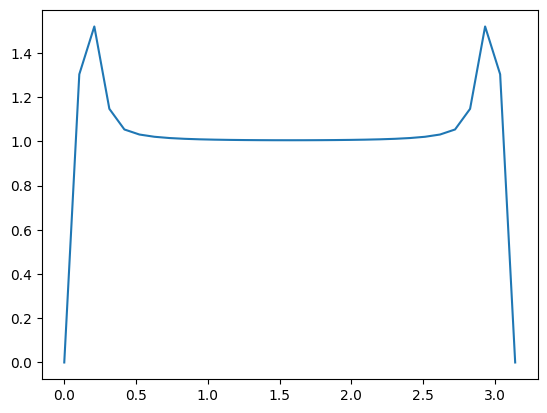

In [10]:
plt.plot(theta_range, np.multiply(2*n, variances))
plt.show()

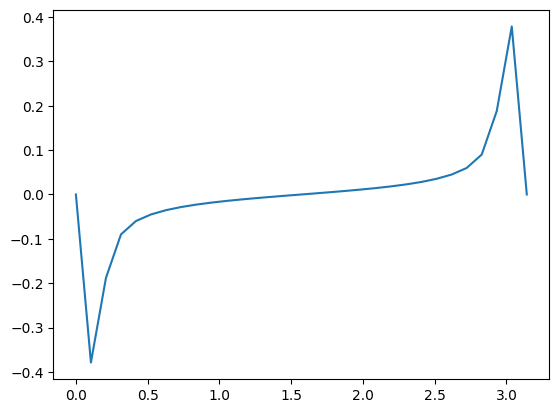

In [11]:
plt.plot(theta_range, np.multiply(np.sqrt(n), means - theta_range))
plt.show()

In [12]:
theta_samples = 51
n_range = [40,200]
theta_range = np.linspace(0, np.pi, theta_samples)

In [13]:
# get the means and variances for each n
means = []
variances = []

for n in n_range:
    _, m, v = calculate_multinom_stats(theta_samples, n)
    means.append(m)
    variances.append(v)

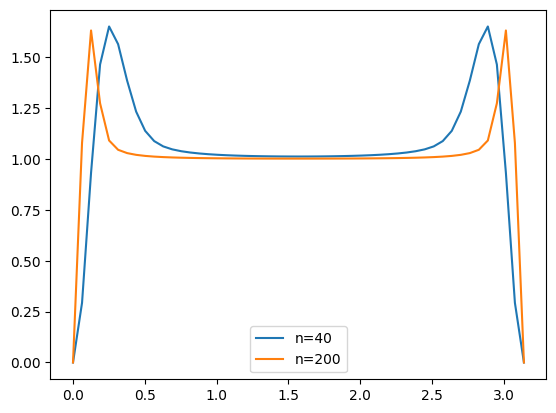

In [14]:
plt.figure()
for n in n_range:
    plt.plot(theta_range, np.multiply(2*n, variances[n_range.index(n)]), label=f'n={n}')

plt.legend()
plt.show()


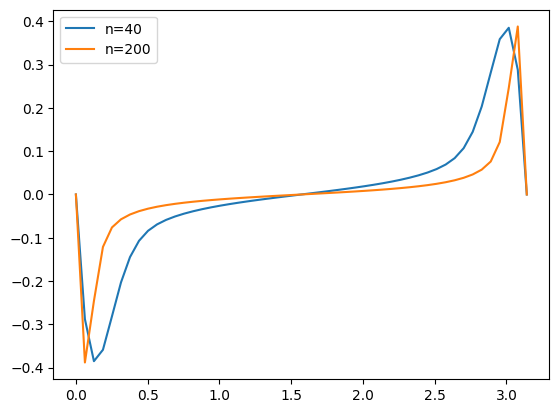

In [15]:
plt.figure()
for n in n_range:
    plt.plot(theta_range, np.multiply(np.sqrt(n), means[n_range.index(n)] - theta_range), label=f'n={n}')

plt.legend()
plt.show()

## Adding PPNRD

### Estimating N

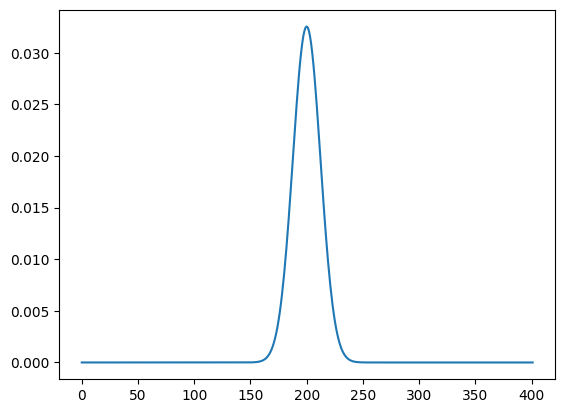

In [16]:
# n_tilde = n_dc + n_ppnrd
# n_dc: double click events
# n_ppnrd: ppnrd-resolved events
n=200

theta = np.pi / 4
p_dc = 1/2 * (np.sin(theta)) ** 2
p_ppnrd = 1/4 * (1 + np.cos(theta) **2)

p_neither = 1 - p_dc - p_ppnrd

p = [p_dc, p_ppnrd, p_neither]
multinom_n_tilde = multinomial(n, p)

# calculate the pmf for n_tilde
pmf = np.zeros(2*(n+1))

for n_tilde in range(2*(n+1)): # can over estimate n if all events are double clicks
    pmf[n_tilde] = np.sum([multinom_n_tilde.pmf([n_dc, (n_tilde-n_dc)/2, n - n_dc - (n_tilde-n_dc) /2]) for n_dc in range(n+1)])

# plot
plt.plot(range(2*(n+1)), pmf)
plt.show()



This will be necessary when it comes to saying how close we are to saturating the bound, since we will need to estimate the value of N to know what the bound is.

### Re-estimating theta with Ñ

With $\tilde{\theta} = \arccos (\frac{2(N_{DB_{H}}'+N_{DB_{V}}')}{\tilde{N}})$ where $\tilde{N} = 2(N_{DB_{H}}' + N_{DB_{V}}')$ 

In [17]:
n = 40

theta = 0.25 * np.pi
delta = 0.25 * np.pi

p_hr = 1 / 8 * (1 + np.cos(theta)) **2
p_vr = 1 / 8 * (1 - np.cos(theta)) **2
p_dc = 1 / 2 * (np.sin(theta)) ** 2
p_other = 1 - p_hr - p_vr - p_dc

p = [p_hr, p_vr, p_dc, p_other]

multinom_db = multinomial(n, p)

0.7853981633974483


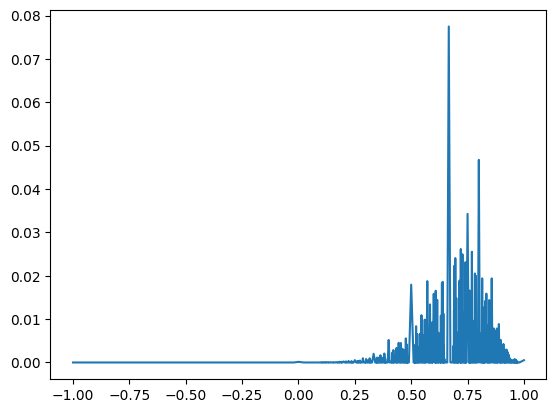

In [18]:
from fractions import Fraction

def get_multinom_ppnrd_ratio_pmf(n, theta):
    print(theta)
    s_range_numerator = np.arange(-2*n, 2*n+1)
    s_range_denominator = np.arange(2, 2*n+1) # exclude division by zero

    s_range = [Fraction(s_num, s_den) for s_num in s_range_numerator for s_den in s_range_denominator]
    # deduplicate the fractions
    deduped_s_range = []
    for i, s in enumerate(s_range):
        if s not in s_range[:i]:
            # deduped_s_range.append(s)
            # ensure s is in the range [-1, 1]
            if s >= -1 and s <= 1:
                deduped_s_range.append(s)

    # sort the fractions
    deduped_s_range = sorted(deduped_s_range)

    p_hr = 1 / 8 * (1 + np.cos(theta)) **2
    p_vr = 1 / 8 * (1 - np.cos(theta)) **2
    p_dc = 1 / 2 * (np.sin(theta)) ** 2
    p_other = 1 - p_hr - p_vr - p_dc

    p = [p_hr, p_vr, p_dc, p_other]

    multinom_ppnrd = multinomial(n, p)

    pmf_s = np.zeros(len(deduped_s_range))
    for s in deduped_s_range:
        pmf = np.sum([multinom_ppnrd.pmf([k, k-s*j/2, (1+s)*j-4*k, n-k-(k-s*j/2)-((1+s)*j-4*k)]) for k in range(n+1) for j in range(2*n+1)])
        pmf_s[deduped_s_range.index(s)] = pmf

    return deduped_s_range, pmf_s

num_samples = 25
pmf_s = get_multinom_ppnrd_ratio_pmf(num_samples, 0.25*np.pi)
plt.plot(pmf_s[0], pmf_s[1])
plt.show()

0.7853981633974483


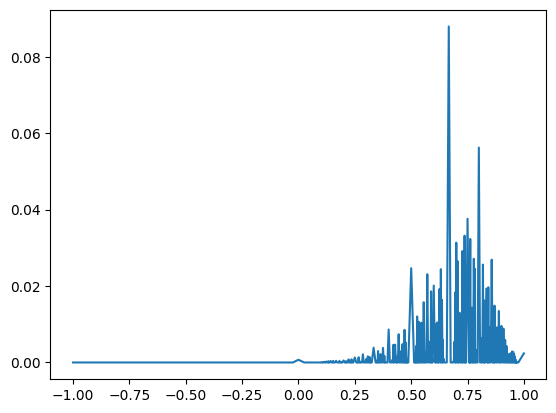

In [19]:
def get_multinom_ppnrd_ratio_pmf(n, theta):
    print(theta)
    s_range_numerator = np.arange(-2*n, 2*n+1)
    s_range_denominator = np.arange(2, 2*n+1) # exclude division by zero

    s_range = [Fraction(s_num, s_den) for s_num in s_range_numerator for s_den in s_range_denominator]
    # deduplicate the fractions
    deduped_s_range = []
    for i, s in enumerate(s_range):
        if s not in s_range[:i]:
            # deduped_s_range.append(s)
            # ensure s is in the range [-1, 1]
            if s >= -1 and s <= 1:
                deduped_s_range.append(s)

    # sort the fractions
    deduped_s_range = sorted(deduped_s_range)

    p_hr = 1 / 8 * (1 + np.cos(theta)) **2
    p_vr = 1 / 8 * (1 - np.cos(theta)) **2
    p_dc = 1 / 2 * (np.sin(theta)) ** 2
    p_other = 1 - p_hr - p_vr - p_dc

    p = [p_hr, p_vr, p_dc, p_other]

    multinom_ppnrd = multinomial(n, p)

    pmf_s = np.zeros(len(deduped_s_range))
    for s in deduped_s_range:
        # arrange the values to evaluate the pmf
        n_counts = [[k, k-s*j/2, (1+s)*j-4*k, n-k-(k-s*j/2)-((1+s)*j-4*k)] for k in range(n+1) for j in range(2*n+1)]

        pmf = np.sum(multinom_ppnrd.pmf(n_counts))
        pmf_s[deduped_s_range.index(s)] = pmf

    return deduped_s_range, pmf_s

num_samples = 20
pmf_s = get_multinom_ppnrd_ratio_pmf(num_samples, 0.25*np.pi)
plt.plot(pmf_s[0], pmf_s[1])
plt.show()

In [20]:
# should be 1
# could be less because of values outside the range [-1, 1] which do not give a valid theta
sum(pmf_s[1])

np.float64(1.000002963817308)

0.0
0.7853981633974483
1.5707963267948966
2.356194490192345
3.141592653589793


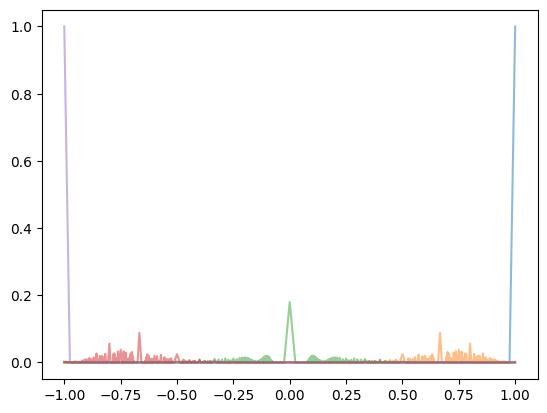

In [21]:
# show some of the pmfs for different thetas
theta_range = np.linspace(0, np.pi, 5)

# get the pmf for each theta
n=20
pmf_z = [get_multinom_ppnrd_ratio_pmf(n, theta) for theta in theta_range]

# plot the pmfs
plt.figure()
for z_range, pmf in pmf_z:
    plt.plot(z_range, pmf, alpha=0.5)

plt.show()

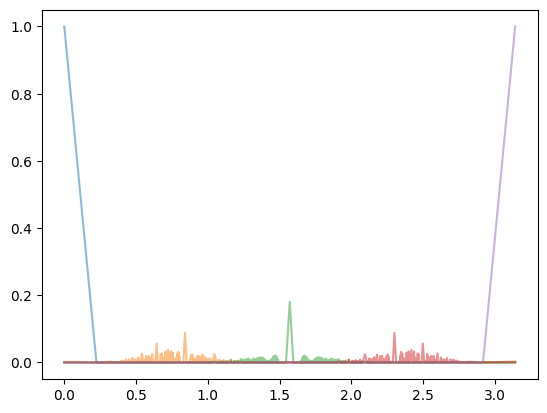

In [22]:
# plot the pmfs with x axis scaled as arccos
plt.figure()
for z_range, pmf in pmf_z:
    # take arccos of the range

    arccos_z = np.arccos([float(z) for z in z_range])
    plt.plot(arccos_z, pmf, alpha=0.5)
    
plt.show()

In [23]:
def calculate_multinom_ppnrd_stats(theta_samples, n):
    theta_range = np.linspace(0, np.pi, theta_samples)
    pmf_z = [get_multinom_ppnrd_ratio_pmf(n, theta) for theta in theta_range]
    
    variances = []
    means = []

    for z_range, pmf in pmf_z:
        arccos_z = np.arccos([float(z) for z in z_range])
        mean = np.sum(arccos_z * pmf)
        var = np.sum((arccos_z) ** 2 * pmf) - mean ** 2

        means.append(mean)
        variances.append(var)

    return theta_range, means, variances


In [24]:
theta_samples = 11
n = 20
theta_range, means, variances = calculate_multinom_ppnrd_stats(theta_samples, n)

0.0
0.3141592653589793
0.6283185307179586
0.9424777960769379
1.2566370614359172
1.5707963267948966
1.8849555921538759
2.199114857512855
2.5132741228718345
2.827433388230814
3.141592653589793


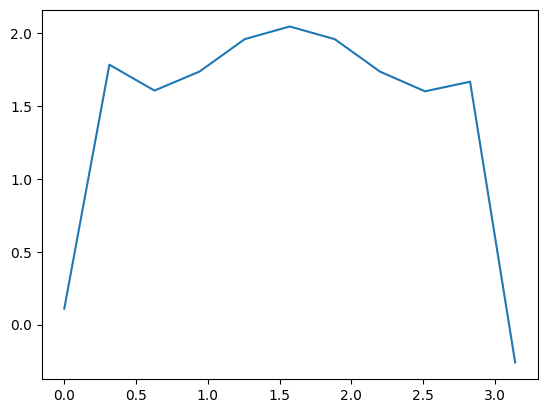

In [25]:
plt.plot(theta_range, np.multiply(2*n, variances))
plt.show()

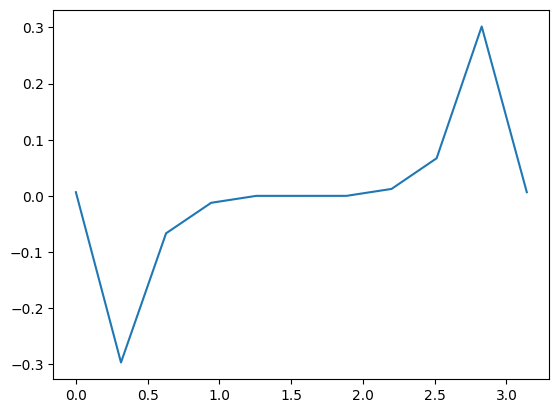

In [26]:
plt.plot(theta_range, np.multiply(means - theta_range, np.sqrt(n)))
plt.show()

In [27]:
theta_samples = 11
n = 40
theta_range, means, variances = calculate_multinom_ppnrd_stats(theta_samples, n)

0.0
0.3141592653589793
0.6283185307179586
0.9424777960769379
1.2566370614359172
1.5707963267948966
1.8849555921538759
2.199114857512855
2.5132741228718345
2.827433388230814
3.141592653589793


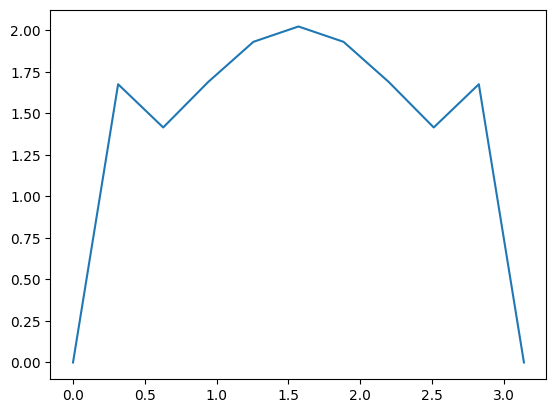

In [28]:
plt.plot(theta_range, np.multiply(2*n, variances))
plt.show()

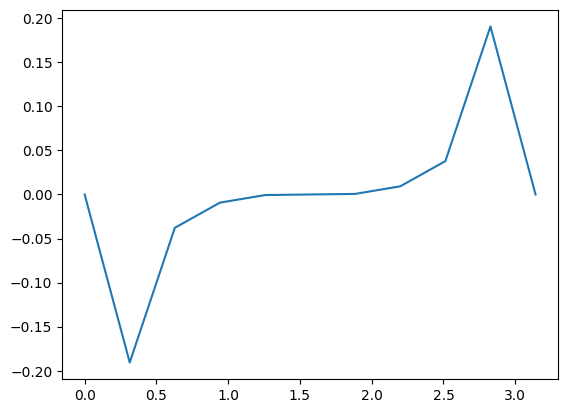

In [29]:
plt.plot(theta_range, np.multiply(means - theta_range, np.sqrt(n)))
plt.show()